# WaveGlow: A Flow-based Generative Network for Speech Synthesis

* https://arxiv.org/abs/1811.00002

## 라이브러리 설치 및 학습 준비

* WaveGlow 구현에는 pytorch와 torchaudio를 사용
* 해당 라이브러리를 설치하고 필요한 라이브러리를 추가

In [ ]:
!pip install torch
!pip install torchaudio

     |████████████████████████████████| 6.7MB 3.9MB/s 


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from math import sqrt

import os
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np
import unicodedata
import re
import time

## 파라미터 설정 및 gpu 설정



*   파라미터를 일일이 설정해서 사용할 수도 있지만 유지보수면에선 좋지 않음
*   파라미터 관리용 클래스를 설정해 필요할 때마다 편리하게 수정하면 유지보수할 때 편리
*   tensorflow의 경우 자동으로 gpu를 잡아주지만, pytorch에서는 gpu 사용 여부를 설정해주어야 함



In [ ]:
class HParams():
    def __init__(self):
        self.n_mel_channels = 80
        self.symbols_embedding_dim=256

        self.encoder_kernel_size=5
        self.encoder_n_convolutions=2
        self.encoder_embedding_dim=256

        self.n_frames_per_step=1
        self.decoder_rnn_dim=256
        self.prenet_dim=128
        self.max_decoder_steps=500
        self.gate_threshold=0.5
        self.p_attention_dropout=0.1
        self.p_decoder_dropout=0.1

        self.attention_rnn_dim=256
        self.attention_dim=128

        self.attention_location_n_filters=32
        self.attention_location_kernel_size=31

        self.postnet_embedding_dim=256
        self.postnet_kernel_size=5
        self.postnet_n_convolutions=5

        self.use_saved_learning_rate=False
        self.learning_rate=1e-3
        self.weight_decay=1e-6
        self.grad_clip_thresh=1.0
        self.batch_size=16
        self.mask_padding=True
    
    
hparams = HParams()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  device = torch.device("cuda")
  print('GPU를 사용할 준비가 되었습니다.')
else:
  device = torch.device("cpu")
  print('CPU 모드입니다. GPU 설정으로 변경해주세요.')

GPU를 사용할 준비가 되었습니다.


## 데이터 준비 및 전처리

* 해당 예제에서는 LJSPEECH 데이터셋을 사용
* LJSPEECH 데이터셋은 7개의 책의 짧은 구문을 단일 화자가 말한 것을 나타내는 데이터셋
* 데이터셋을 다운받기 위해 url을 설정하고 torchaudio를 통해 다운로드
* https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2



In [ ]:
LJSpeech_url = 'https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2'
train_dataset = torchaudio.datasets.LJSPEECH("", url=LJSpeech_url, download=True)

print('Download 완료')


Download 완료


In [ ]:
tt = []
for i in range(200):
  tt.append(train_dataset[i])
print(len(tt))

200




*   그다음 data를 편리하게 사용하기 위해 dataloader 객체와 dataloader에 사용되는 collate function을 정의한다.
*   collate function은 dataloader에 입력되는 데이터를 동일한 형상으로 맞춰주는 역할을 한다.



## WaveGlow

In [ ]:
hop_length = 256
max_steps = 15872

class Collate():
    def __init__(self):
        self.wav_to_mel = torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_mels=80, win_length=1024, hop_length=hop_length, f_min=0.0, f_max=8000.0, n_fft=1024)

    def __call__(self, batch):
        # batch: N_batch * [wav, sample_rate, text, text_normalized]

        x_batch = []
        c_batch = []
        for idx in range(len(batch)):
            x = batch[idx][0].squeeze()
            c = self.wav_to_mel(x)
            c = self.dynamic_range_compression(c)
            
            pad = (x.shape[0] // hop_length + 1) * hop_length - x.shape[0]
            pad_l = pad // 2
            pad_r = pad // 2 + pad % 2

            # zero pad for quantized signal
            x = np.pad(x, (pad_l, pad_r), mode="constant", constant_values=0.0)
            x = torch.tensor(x)

            max_time_frames = max_steps // hop_length
            s = np.random.randint(0, c.shape[1] - max_time_frames)
            ts = s * hop_length
            x = x[ts:ts + hop_length * max_time_frames]
            c = c[:,s:s + max_time_frames]
            
            x_batch.append(x)
            c_batch.append(c)

        x_batch = torch.stack(x_batch)
        c_batch = torch.stack(c_batch)

        return x_batch, c_batch

    def dynamic_range_compression(self, x, C=1, clip_val=1e-5):
        return torch.log(torch.clamp(x, min=clip_val) * C)

collate_fn = Collate()
train_loader = DataLoader(tt, batch_size=8, shuffle=True, drop_last=False, collate_fn=collate_fn)
x_batch, c_batch = next(iter(train_loader))

print('audio batch shape:', x_batch.shape)
print('mel batch shape:', c_batch.shape)
print('Data 전처리 완료')

audio batch shape: torch.Size([8, 15872])
mel batch shape: torch.Size([8, 80, 62])
Data 전처리 완료


### UpsampleConv

*   ConvTranspose1d로 간단히 구현
*   in_channels와 out_channels는 mel-spectrogram의 주파수 축 차원과 동일하게 80으로 설정
*   mel-spectrogram의 frame 길이는 audio를 temporal axis로 256배 축소한 것으로 설정되어 있음
*   따라서 audio의 길이와 동일하게 늘려주기 위하여 stride를 256로 설정
*   주변 frame 값들도 고려하기 위하여 kernel_size를 256보다 큰 1024로 설정



In [ ]:
class UpsampleConv(nn.Module):
    def __init__(self, n_mel_channels=80):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose1d(n_mel_channels, n_mel_channels, kernel_size=1024, stride=256)

    def forward(self, spect):
        spect = self.upsample(spect)
        return spect

### Invertible1x1Conv




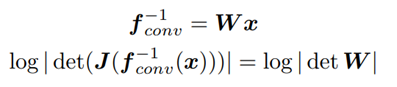

*   1x1 convolution을 구현
*   채널을 섞을 때 발생하는 log-determinant는 log|detW| 이며, 이를 매 프레임에 대해서 동일하게 적용하므로 최종적인 log-determinant는 batch_size * frame_length * log|detW|
*   역변환은 W의 역행렬을 구하여 진행



In [ ]:
class Invertible1x1Conv(torch.nn.Module):
    def __init__(self, c):
        super().__init__()
        self.conv = torch.nn.Conv1d(c, c, kernel_size=1, stride=1, padding=0, bias=False)
        W = torch.qr(torch.FloatTensor(c, c).normal_())[0]
        if torch.det(W) < 0:
            W[:,0] = -1*W[:,0]
        W = W.view(c, c, 1)
        self.conv.weight.data = W

    def forward(self, x, log_det_sum):
        # shape
        z = self.conv(x)
        
        B, _, T = x.size()
        W = self.conv.weight.squeeze()
        log_det_W = B * T * torch.logdet(W)
        log_det_sum = log_det_sum + log_det_W

        return z, log_det_sum

    def reverse(self, z):
        W = self.conv.weight.squeeze()
        W_inverse = W.float().inverse()
        W_inverse = Variable(W_inverse[..., None])
        self.W_inverse = W_inverse
        x = F.conv1d(z, self.W_inverse, bias=None, stride=1, padding=0)
        
        return x

### Non-causal WaveNet


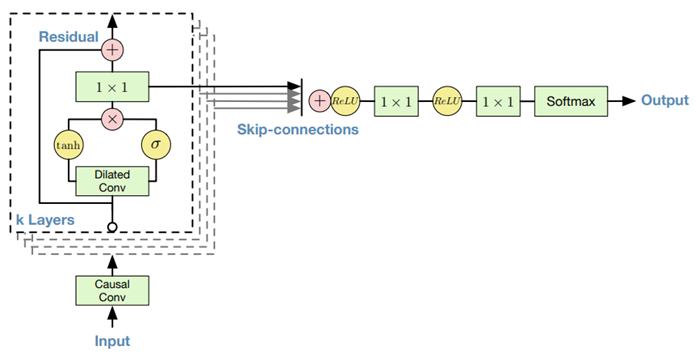

*   Non-causal WaveNet을 구현
*   Mel-spectrogram를 local condition으로 하여 affine coupling layer에서 사용될 log_s, t 값을 계산
*   Receptive field를 넓게 설정하기 위하여 layer를 쌓으면서 dilation을 2의 배수로 증가



In [ ]:
class WN(nn.Module):
    """
    This is the WaveNet like layer for the affine coupling.  The primary difference
    from WaveNet is the convolutions need not be causal.  There is also no dilation
    size reset.  The dilation only doubles on each layer
    """
    def __init__(self, in_channels, cin_channels, n_layers=8, n_channels=128,
                 kernel_size=3):
        super(WN, self).__init__()
        assert(kernel_size % 2 == 1)
        assert(n_channels % 2 == 0)
        self.n_layers = n_layers
        self.n_channels = n_channels
        self.in_layers = torch.nn.ModuleList()
        self.res_skip_layers = torch.nn.ModuleList()

        start = torch.nn.Conv1d(in_channels, n_channels, 1)
        start = torch.nn.utils.weight_norm(start, name='weight')
        self.start = start

        # Initializing last layer to 0 makes the affine coupling layers
        # do nothing at first.  This helps with training stability
        end = torch.nn.Conv1d(n_channels, 2*in_channels, 1)
        end.weight.data.zero_()
        end.bias.data.zero_()
        self.end = end

        cond_layer = torch.nn.Conv1d(cin_channels, 2*n_channels*n_layers, 1)
        self.cond_layer = torch.nn.utils.weight_norm(cond_layer, name='weight')

        for i in range(n_layers):
            dilation = 2 ** i
            padding = int((kernel_size*dilation - dilation)/2)
            in_layer = torch.nn.Conv1d(n_channels, 2*n_channels, kernel_size,
                                       dilation=dilation, padding=padding)
            in_layer = torch.nn.utils.weight_norm(in_layer, name='weight')
            self.in_layers.append(in_layer)

            # last one is not necessary
            if i < n_layers - 1:
                res_skip_channels = 2*n_channels
            else:
                res_skip_channels = n_channels
            res_skip_layer = torch.nn.Conv1d(n_channels, res_skip_channels, 1)
            res_skip_layer = torch.nn.utils.weight_norm(res_skip_layer, name='weight')
            self.res_skip_layers.append(res_skip_layer)

    def forward(self, audio, spect):
        audio = self.start(audio)
        output = torch.zeros_like(audio)
        n_channels_tensor = torch.IntTensor([self.n_channels])

        spect = self.cond_layer(spect)

        for i in range(self.n_layers):
            spect_offset = i*2*self.n_channels
            acts = self.fused_add_tanh_sigmoid_multiply(
                self.in_layers[i](audio),
                spect[:,spect_offset:spect_offset+2*self.n_channels,:],
                n_channels_tensor)

            res_skip_acts = self.res_skip_layers[i](acts)
            if i < self.n_layers - 1:
                audio = audio + res_skip_acts[:,:self.n_channels,:]
                output = output + res_skip_acts[:,self.n_channels:,:]
            else:
                output = output + res_skip_acts

        return self.end(output).chunk(2,1)


    def fused_add_tanh_sigmoid_multiply(self, input_a, input_b, n_channels):
        n_channels_int = n_channels[0]
        in_act = input_a+input_b
        t_act = torch.tanh(in_act[:, :n_channels_int, :])
        s_act = torch.sigmoid(in_act[:, n_channels_int:, :])
        acts = t_act * s_act
        return acts

### AffineCouplingLayer




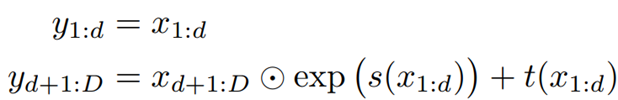

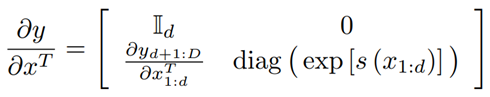

*   Affine coupling layer를 구현
*   input의 절반(x_a)은 변환을 하지 않고, 나머지 절반(x_b)은 affine transform을 적용
*   이때, s와 t는 x_a를 아까 구현한 non-causal WaveNet에 통과시켜 얻음
*   Jacobian matrix를 고려하면 determinant는 대각 성분의 곱이 되고, 최종적인 log-determinant는 sum(log_s)


In [ ]:
class AffineCouplingLayer(nn.Module):
    def __init__(self, in_channels, cin_channels):
        super().__init__()
        self.WN = WN(in_channels, cin_channels)

    def forward(self, x, c, log_det_sum):

        x_a, x_b = x.chunk(2,1)
        log_s, t = self.WN(x_a, c)
        x_b = torch.exp(log_s) * x_b + t
        log_det_sum = log_det_sum + log_s.sum()
        z = torch.cat((x_a, x_b), dim=1)

        return z, c, log_det_sum

    def reverse(self, z, c):
        z_a, z_b = z.chunk(2,1)
        log_s, t = self.WN(z_a, c)
        z_b = torch.exp(-log_s) * (z_b - t)

        x = torch.cat((z_a, z_b), dim=1)

        return x, c


### WaveGlow 모델

In [ ]:
from math import pi, log

class WaveGlow(torch.nn.Module):
    def __init__(self, n_mel_channels=80, n_flows=12, n_group=8, n_early_every=4,
                 n_early_size=2):
        super(WaveGlow, self).__init__()

        self.upsample = UpsampleConv(n_mel_channels)
        assert(n_group % 2 == 0)
        self.n_flows = n_flows
        self.n_group = n_group
        self.n_early_every = n_early_every
        self.n_early_size = n_early_size
        self.coupling_layer = torch.nn.ModuleList()
        self.convinv = torch.nn.ModuleList()
        self.sigma = 1.0

        n_half = int(n_group/2)

        # Set up layers with the right sizes based on how many dimensions
        # have been output already
        n_remaining_channels = n_group
        for k in range(n_flows):
            if k % self.n_early_every == 0 and k > 0:
                n_half = n_half - int(self.n_early_size/2)
                n_remaining_channels = n_remaining_channels - self.n_early_size
            self.convinv.append(Invertible1x1Conv(n_remaining_channels))
            self.coupling_layer.append(AffineCouplingLayer(n_half, n_mel_channels*n_group))
        self.n_remaining_channels = n_remaining_channels  # Useful during inference

    def forward(self, audio, spect):
        audio = audio.squeeze(1)

        #  Upsample spectrogram to size of audio
        spect = self.upsample(spect)
        assert(spect.size(2) >= audio.size(1))
        if spect.size(2) > audio.size(1):
            spect = spect[:, :, :audio.size(1)]

        spect = spect.unfold(2, self.n_group, self.n_group).permute(0, 2, 1, 3)
        spect = spect.contiguous().view(spect.size(0), spect.size(1), -1).permute(0, 2, 1)

        audio = audio.unfold(1, self.n_group, self.n_group).permute(0, 2, 1)

        output_audio = []
        log_det_sum = 0.0

        for k in range(self.n_flows):
            if k % self.n_early_every == 0 and k > 0:
                output_audio.append(audio[:,:self.n_early_size,:])
                audio = audio[:,self.n_early_size:,:]
            audio, log_det_sum = self.convinv[k](audio, log_det_sum)
            audio, spect, log_det_sum = self.coupling_layer[k](audio, spect, log_det_sum)

        output_audio.append(audio)

        z = torch.cat(output_audio,1)

        log_p = 0.5 * (- log(2.0 * pi) - z.pow(2)).sum() / (z.size(0)*z.size(1)*z.size(2))
        log_det = log_det_sum /  (z.size(0)*z.size(1)*z.size(2))
        
        return log_p, log_det, output_audio

## 모델 및 옵티마이저 선언

In [ ]:
model = WaveGlow().to(device)
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 모델 학습

In [ ]:
iteration = 0

for epoch in range(20):
  print("Epoch: {}".format(epoch))
  for i, (x, c) in enumerate(train_loader):
    start = time.perf_counter()
    model.zero_grad()
    x, c = x.to(device), c.to(device)
    log_p, logdet, _ = model(x, c)
    log_p, logdet = torch.mean(log_p), torch.mean(logdet)

    loss = -(log_p + logdet)
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.)
    
    optimizer.step()

    duration = time.perf_counter() - start
    print("Iteratoin: {}, [NLL, Log p(z), Log Det]: [{:.4f}, {:.4f}, {:.4f}], {:.2f}s/it".format(iteration, loss.item(), log_p.item(), logdet.item(), duration))
    
    iteration += 1

Epoch: 0
Iteratoin: 0, [NLL, Log p(z), Log Det]: [0.9227, -0.9227, 0.0000], 2.19s/it
Iteratoin: 1, [NLL, Log p(z), Log Det]: [0.7953, -0.9217, 0.1264], 1.88s/it
Iteratoin: 2, [NLL, Log p(z), Log Det]: [0.2011, -0.9977, 0.7967], 1.88s/it
Iteratoin: 3, [NLL, Log p(z), Log Det]: [50.1886, -52.5677, 2.3791], 1.89s/it
Iteratoin: 4, [NLL, Log p(z), Log Det]: [153.7714, -156.0886, 2.3172], 1.88s/it
Iteratoin: 5, [NLL, Log p(z), Log Det]: [32.9128, -34.6918, 1.7790], 1.89s/it
Iteratoin: 6, [NLL, Log p(z), Log Det]: [132.2629, -134.3328, 2.0699], 1.90s/it
Iteratoin: 7, [NLL, Log p(z), Log Det]: [9.5101, -11.0897, 1.5796], 1.90s/it
Iteratoin: 8, [NLL, Log p(z), Log Det]: [1.2228, -2.0569, 0.8341], 1.91s/it
Iteratoin: 9, [NLL, Log p(z), Log Det]: [0.8604, -1.1492, 0.2888], 1.92s/it
Iteratoin: 10, [NLL, Log p(z), Log Det]: [0.5513, -1.1449, 0.5936], 1.97s/it
Iteratoin: 11, [NLL, Log p(z), Log Det]: [-0.0109, -1.1832, 1.1941], 1.93s/it
Iteratoin: 12, [NLL, Log p(z), Log Det]: [-0.2733, -1.5339, 1.8